## Business Problem

## Data Understanding

## Data Preparation

### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from bs4 import BeautifulSoup

import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import string

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, plot_roc_curve

from sklearn.inspection import permutation_importance

In [2]:
df = pd.read_csv('data/IMDB_Dataset.csv')

In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Check for duplicates

In [4]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


A small amount of duplicates. Since the data does not distinguish the media associated with the review, we will not remove any duplicates.

### Check Target Distribution

In [5]:
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

This is a balanced dataset

### Check Null Values

In [6]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [7]:
df.loc[0][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [9]:
review = df.loc[0][0]

### Text Cleaning

In [22]:
def text_preprocessor(review):
    # Strip html text
    soup = BeautifulSoup(review, "lxml")
    data = soup.get_text()
    # Lower case all text
    data = data.lower()
    # Remove edge cases with multiple periods
    pattern = re.compile(r'\s+')
    data = re.sub(pattern, ' ', data.replace('.', ' '))
    # Remove punctuation and other special characters
    pattern = r'[^a-zA-Z\s]'
    data = re.sub(pattern, '', data)
    # Tokenize
    data = word_tokenize(data)
    # Get list of nltk's stopwords
    stopwords_list = stopwords.words('english')
    # Remove stop words
    data = [word for word in data if word not in stopwords_list]
    # Initialize a PortStemmer object
    stemmer = PorterStemmer()
    # Convert the tokens into their stem
    data = [stemmer.stem(token) for token in data]
    # Convert the list of words back into
    # a string by joining each word with a space
    data = ' '.join(data)
    # Remove double spaces
    data = data.replace('  ', ' ')
    # Remove opening and trailing spaces
    data = data.strip()
    # Return the cleaned text data
    return data

In [23]:
df.review = df.review.apply(text_preprocessor)

In [24]:
print(df.review[:5])

0    one review mention watch oz episod youll hook ...
1    wonder littl product film techniqu unassum old...
2    thought wonder way spend time hot summer weeke...
Name: review, dtype: object


### Data Exploration

#### Number of words per review

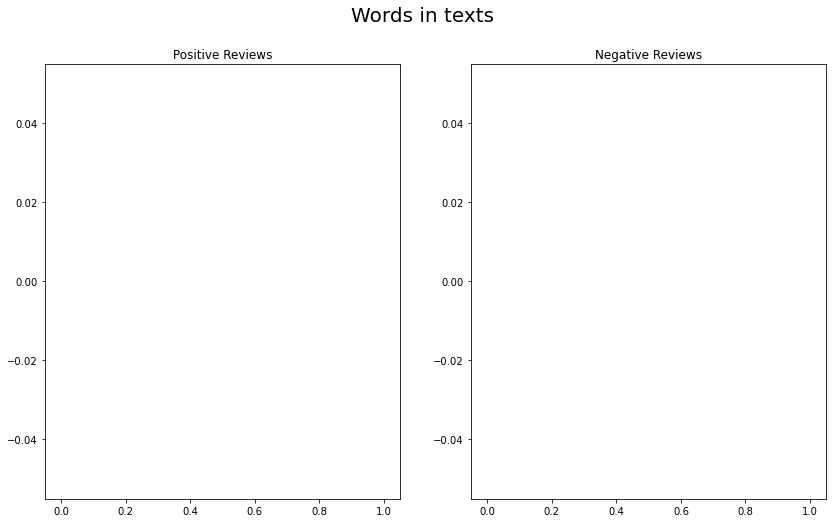

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
length_good_reviews = df[df['sentiment'] == 'positive']['review'].str.split().map(lambda x: len(x))
ax1.hist(length_good_reviews, color='blue')
ax1.set_title('Positive Reviews')
length_bad_reviews = df[df['sentiment'] == 'negative']['review'].str.split().map(lambda x: len(x))
ax2.hist(length_bad_reviews, color='green')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts', fontsize=20)
plt.show()

#### Mean word length per review

/Users/dan/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/dan/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/numpy/lib/histograms.py:908: RuntimeWarning:

invalid value encountered in true_divide



Text(0.5, 0.98, 'Mean word length per review')

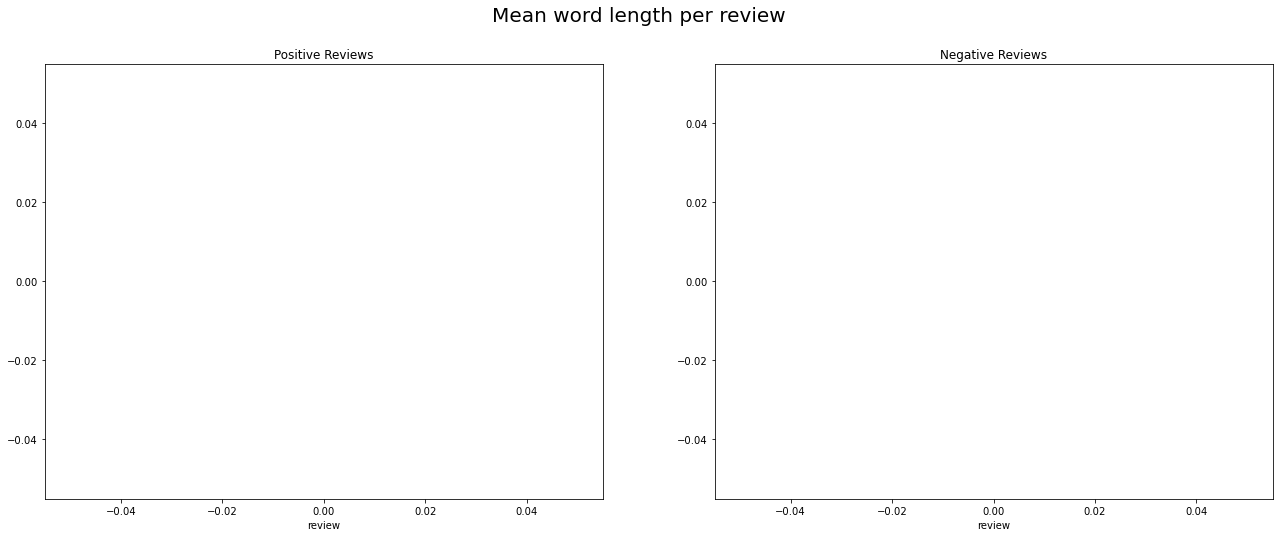

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))
pos_word = df[df['sentiment'] == 'positive']['review'].str.split().apply(lambda x: [
    len(i) for i in x])
sns.distplot(pos_word.map(lambda x: np.mean(x)), ax=ax1, color='blue')
ax1.set_title('Positive Reviews')
neg_word = df[df['sentiment'] == 'negative']['review'].str.split().apply(lambda x: [
    len(i) for i in x])
sns.distplot(neg_word.map(lambda x: np.mean(x)), ax=ax2, color='green')
ax2.set_title('Negative Reviews')
fig.suptitle('Mean word length per review', fontsize=20)

### Grab all words in reviews

In [27]:
def get_all_words(text):
    words = []
    for x in text:
        for y in x.split():
            words.append(y.strip())
    return words
all_words = get_all_words(df.review)
all_words[:10]

['one',
 'review',
 'mention',
 'watch',
 'oz',
 'episod',
 'youll',
 'hook',
 'right',
 'exactli']

### Count all words in reviews

In [28]:
from collections import Counter
counter = Counter(all_words)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'movi': 101385,
 'film': 94157,
 'one': 53941,
 'like': 44144,
 'time': 30810,
 'good': 29423,
 'make': 28675,
 'charact': 28038,
 'see': 27867,
 'get': 27820}

### Create a function to find most common n-grams
credit: https://www.kaggle.com/madz2000/sentiment-analysis-cleaning-eda-bert-88-acc/notebook

In [29]:
def get_top_text_ngrams(text, num_words, ngram):
    vec = TfidfVectorizer(ngram_range=(ngram, ngram)).fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:num_words]

### Unigram Analysis

In [31]:
most_common_uni_pos = get_top_text_ngrams(df.review[df.sentiment=='positive'], 20, 1)
most_common_uni_pos = dict(most_common_uni_pos)
temp = pd.DataFrame(columns=["Weighted_words", 'TFIDF Score'])
temp["Weighted_words"] = list(most_common_uni_pos.keys())
temp["TFIDF"] = list(most_common_uni_pos.values())
fig = px.bar(temp, x="TFIDF Score", y="Weighted_words", title='Weighted Words in Positive Reviews', orientation='h',
             width=700, height=700, color='Weighted_words')
fig.show()

In [32]:
most_common_uni_neg = get_top_text_ngrams(df.review[df.sentiment=='negative'], 20, 1)
most_common_uni_neg = dict(most_common_uni_neg)
temp = pd.DataFrame(columns=["Weighted_words", 'TFIDF Score'])
temp["Weighted_words"] = list(most_common_uni_neg.keys())
temp["TFIDF"] = list(most_common_uni_neg.values())
fig = px.bar(temp, x="TFIDF Score", y="Weighted_words", title='Weighted Words in Negative Reviews', orientation='h',
             width=700, height=700, color='Weighted_words')
fig.show()

### Bigram Analysis

In [34]:
most_common_bi_pos = get_top_text_ngrams(df.review[df.sentiment=='positive'],20,2)
most_common_bi_pos = dict(most_common_bi_pos)
temp = pd.DataFrame(columns = ["Weighted_words" , 'TFIDF Score'])
temp["Weighted_words"] = list(most_common_bi_pos.keys())
temp["TFIDF"] = list(most_common_bi_pos.values())
fig = px.bar(temp, x="TFIDF Score", y="Weighted_words", title='Weighted Bigrams in Positive Reviews', orientation='h', 
             width=700, height=700,color='Weighted_words')
fig.show()

In [35]:
most_common_bi_neg = get_top_text_ngrams(df.review[df.sentiment=='negative'],20,2)
most_common_bi_neg = dict(most_common_bi_neg)
temp = pd.DataFrame(columns = ["Weighted_words" , 'TFIDF Score'])
temp["Weighted_words"] = list(most_common_bi_neg.keys())
temp["TFIDF"] = list(most_common_bi_neg.values())
fig = px.bar(temp, x="TFIDF Score", y="Weighted_words", title='Weighted Bigrams in Negative Reviews', orientation='h', 
             width=700, height=700,color='Weighted_words')
fig.show()

### Trigram Analysis

In [37]:
most_common_tri_pos = get_top_text_ngrams(df.review[df.sentiment=='positive'],20,3)
most_common_tri_pos = dict(most_common_tri_pos)
temp = pd.DataFrame(columns = ["Weighted_words" , 'TFIDF Score'])
temp["Weighted_words"] = list(most_common_tri_pos.keys())
temp["TFIDF"] = list(most_common_tri_pos.values())
fig = px.bar(temp, x="TFIDF Score", y="Weighted_words", title='Weighted Trigrams Positive Reviews', orientation='h', 
             width=700, height=700,color='Weighted_words')
fig.show()

In [38]:
most_common_tri_neg = get_top_text_ngrams(df.review[df.sentiment=='negative'],20,3)
most_common_tri_neg = dict(most_common_tri_neg)
temp = pd.DataFrame(columns = ["Weighted_words" , 'TFIDF Score'])
temp["Weighted_words"] = list(most_common_tri_neg.keys())
temp["TFIDF"] = list(most_common_tri_neg.values())
fig = px.bar(temp, x="TFIDF Score", y="Weighted_words", title='Weighted Trigrams in Negative Reviews', orientation='h', 
             width=700, height=700,color='Weighted_words')
fig.show()

### Encode Target Column

In [39]:
df.sentiment.replace("positive" , 1 , inplace = True)
df.sentiment.replace("negative" , 0 , inplace = True)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(df[['review']], df.sentiment, random_state = 42)

In [165]:
count = CountVectorizer()
tfidf = TfidfVectorizer()

In [166]:
from sklearn.pipeline import make_pipeline

models = {'lr_count': make_pipeline(count, LogisticRegression(max_iter=375, random_state=42)),
          'dt_count': make_pipeline(count, DecisionTreeClassifier(random_state=42)),
          'rf_count': make_pipeline(count, RandomForestClassifier(random_state=42)),
          'lr_tfidf': make_pipeline(tfidf, LogisticRegression(max_iter=375, random_state=42)),
          'dt_tfidf': make_pipeline(tfidf, DecisionTreeClassifier(random_state=42)),
          'rf_tfidf': make_pipeline(tfidf, RandomForestClassifier(random_state=42))}

In [167]:
from sklearn.model_selection import cross_val_score

baseline_scores = {}

for model in models:
    score = cross_val_score(models[model], X_train.iloc[:,0], y_train, scoring='f1')
    baseline_scores[model] = score.mean()
    
baseline_scores

{'lr_count': 0.8756128986644571,
 'dt_count': 0.7171327201737887,
 'rf_count': 0.8513636098212689,
 'lr_tfidf': 0.8899069735668492,
 'dt_tfidf': 0.7103410288997866,
 'rf_tfidf': 0.8462421184225345}

### Fit all training data on optimized model

In [104]:
lr_pipeline = models['lr_tfidf']

In [105]:
lr_pipeline.fit(X_train.iloc[:,0], y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression',
                 LogisticRegression(max_iter=375, random_state=42))])

In [47]:
def evaluate(estimator, X_train, X_test, y_train, y_test, roc_auc='proba'):
    '''
    Evaluation function to show a few scores for both the train and test set
    Also shows a confusion matrix for the test set

    roc_auc allows you to set how to calculate the roc_auc score: 
    'dec' for decision_function or 'proba' for predict_proba 
    If roc_auc == 'skip', then it ignores calculating the roc_auc_score

    Function takes in:
    'estimator' a fit sklearn model object
    'X_train' dataframe
    'X_test' dataframe
    'y_train' series
    'y_test' series
    'roc_auc' string that defines ...
    '''
    # grab predictions
    train_preds = estimator.predict(X_train)
    test_preds = estimator.predict(X_test)

    # output needed for roc_auc_score
    if roc_auc == 'skip':  # skips calculating the roc_auc_score
        train_out = False
        test_out = False
    elif roc_auc == 'dec':  # not all classifiers have decision_function
        train_out = estimator.decision_function(X_train)
        test_out = estimator.decision_function(X_test)
    elif roc_auc == 'proba':
        train_out = estimator.predict_proba(
            X_train)[:, 1]  # proba for the 1 class
        test_out = estimator.predict_proba(X_test)[:, 1]
    else:
        raise Exception(
            "The value for roc_auc should be 'skip', 'dec' or 'proba'.")

    # print scores
    print("Train Scores")
    print("------------")
    print(f"Accuracy: {accuracy_score(y_train, train_preds)}")
    print(f"Precision: {precision_score(y_train, train_preds)}")
    print(f"Recall: {recall_score(y_train, train_preds)}")
    print(f"F1 Score: {f1_score(y_train, train_preds)}")
    if type(train_out) == np.ndarray:  # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_train, train_out)}")
    print("----" * 5)
    print("Test Scores")
    print("-----------")
    print(f"Accuracy: {accuracy_score(y_test, test_preds)}")
    print(f"Precision: {precision_score(y_test, test_preds)}")
    print(f"Recall: {recall_score(y_test, test_preds)}")
    print(f"F1 Score: {f1_score(y_test, test_preds)}")
    if type(test_out) == np.ndarray:
        print(f"ROC-AUC: {roc_auc_score(y_test, test_out)}")

    # plot test confusion matrix
    plot_confusion_matrix(estimator, X_test, y_test, values_format=',.5g')
    plt.grid(False)
    plt.show()

Train Scores
------------
Accuracy: 0.9281066666666666
Precision: 0.9213346708199145
Recall: 0.9353593825373855
F1 Score: 0.9282940581945849
ROC-AUC: 0.978660586482951
--------------------
Test Scores
-----------
Accuracy: 0.89248
Precision: 0.8861424378186312
Recall: 0.904303957118083
F1 Score: 0.8951310861423221
ROC-AUC: 0.9595893116916947


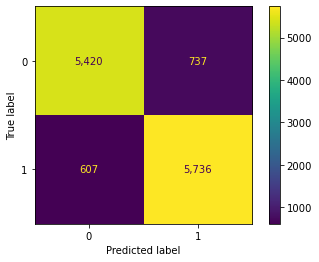

In [48]:
evaluate(lr_pipeline, X_train.iloc[:,0], X_test.iloc[:,0], y_train, y_test, roc_auc='proba')

### Grab Feature Importances

In [193]:
coefs = lr_pipeline.steps[1][1].coef_

In [161]:
coefs.arg

<bound method LinearClassifierMixin.decision_function of LogisticRegression(max_iter=375, random_state=42)>

In [91]:
X_test.iloc[:,0]

33553    realli like summerslam due look arena curtain ...
9427     mani televis show appeal quit mani differ kind...
199      film quickli get major chase scene ever increa...
12447    jane austen would definit approv onegwyneth pa...
39489    expect somewhat high went see movi thought ste...
                               ...                        
9771     first separ stori film stori second continu wa...
34737    obviou flaw horribl horribl script movi potent...
30390    brillianc movi even compet dentist pretti scar...
6797     yaitat japan realli fun show realli like shown...
37270    wonder funni aweinspir featur pioneer turntabl...
Name: review, Length: 12500, dtype: object

In [148]:
X_train.iloc[:,0]

27434    figur altern realiti teen flick precis ferri b...
13400    kind movi want good suck first thing hell punk...
883      far worst movi ive ever seen that compar alexa...
7303     aw aw aw love origin film funni charm heart pi...
45124    fragil carn great period although sometim hesi...
                               ...                        
11284    shadow magic recaptur joy amaz first movi audi...
44732    found movi quit enjoy fairli entertain good ch...
38158    avoid one terribl movi excit pointless murder ...
860      product quit surpris absolut love obscur earli...
15795    decent movi although littl bit short time pack...
Name: review, Length: 37500, dtype: object

In [142]:
feats = lr_pipeline.steps[1][1].coef_
feature_imps = dict(zip(X_train.iloc[:,0], feats))
feature_imps

{'figur altern realiti teen flick precis ferri bueller type charact leader cheat ring yeah know meant compar ferri bueller least orangestoorang way nonetheless bottomlin galaxi away even even minor classic watchabl though your expect much said main charact charm premis wear thin write isnt clever movi deliv enough laugh twist tension keep interest honest continu watch watch hope see anyth suddenli click didnt stylish wouldnt recommend movi btw seem odd see mari tyler moor princip she truli miscast hope paycheck inordin big': array([-0.06394908, -0.13714294, -0.02193127, ..., -0.02424731,
        -0.01834971, -0.00131916])}

In [141]:
feature_imps.keys()

dict_keys(['review'])

In [93]:
# visualizing feature importances
# creating list of column names
feat_names = list(X_test.iloc[:,0])

# Sort feature importances in descending order
indices = np.argsort(feats)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [feat_names[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X_train.shape[1]), feats[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=90)

# Show plot
plt.show()

TypeError: only integer scalar arrays can be converted to a scalar index

In [85]:
features = lr_pipeline.steps[1][1].coef_
feature_importances = dict(zip(X_test.iloc[:,0], features))
feature_importances

{'realli like summerslam due look arena curtain look overal interest reason anyway could one best summerslam ever wwf didnt lex luger main event yokozuna time ok huge fat man vs strong man im glad time chang terribl main event like everi match luger terribl match card razor ramon vs ted dibias steiner brother vs heavenli bodi shawn michael vs curt hene event shawn name big monster bodi guard diesel ir vs kid bret hart first take doink take jerri lawler stuff hart lawler alway interest ludvig borga destroy marti jannetti undertak took giant gonzalez anoth terribl match smoke gunn tatanka took bam bam bigelow headshrink yokozuna defend world titl lex luger match bore terribl end howev deserv': array([-0.06394908, -0.13714294, -0.02193127, ..., -0.02424731,
        -0.01834971, -0.00131916])}

### Plot Feature Importances

In [86]:
feature_importances = feature_importances.nlargest(10)
feature_importances.plot(kind='barh', figsize=(10, 10))

AttributeError: 'dict' object has no attribute 'nlargest'

In [171]:
lr_pipeline.steps[-1][-1].coef_

array([[-0.06394908, -0.13714294, -0.02193127, ..., -0.02424731,
        -0.01834971, -0.00131916]])

In [169]:
lr_pipeline.steps[0][-1]

TfidfVectorizer()

In [168]:
lr_pipeline.steps[1][1]

LogisticRegression(max_iter=375, random_state=42)

In [ ]:
lr_pipeline.steps[1][1].coef_

In [172]:
# the fit tfidf vectorizer
transformer = lr_pipeline.steps[0][-1]
# the fit logistic regression model
lr_model = lr_pipeline.steps[-1][-1].coef_

In [173]:
X_inspect = transformer.transform(X_test.iloc[:,0]).toarray()

In [175]:
X_inspect

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [52]:
importance = permutation_importance(lr_model, X_inspect, y_test, random_state=42, scoring='f1')

KeyboardInterrupt: 

In [ ]:
# Zip the names of the features 
# with the features permutation importance
importance_weights = list(zip(transformer.get_feature_names(), importance['importances_mean']))

# Sort the weights in descending order
sorted(importance_weights, key=lambda x: x[1], reverse=True)[:100]